# Notebook for extracting pixel level information from interferogram
### Import of packages and define variables

In [210]:
#%pip install rioxarray xarray earthpy xarray_leaflet
import rasterio as ro
import numpy as np
from rasterio.plot import show
from tqdm import tqdm
import descarteslabs.workflows as wf
from ipyleaflet import Map, basemaps, GeoData, CircleMarker, Popup, GeoJSON, LegendControl, LocalTileLayer
import ipyleaflet
import xarray_leaflet
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
from shapely.geometry import Polygon, Point
import pandas as pd
import PIL
from base64 import b64encode
from io import BytesIO

In [102]:
ifgPath = "./data/20200730_20200805_IW1_Stack_ifg_deb_dinsar_flt_ML_TC_big.tif"
croppedPath = "./data/cropped.tiff"

lat, lon, zoom = 33.8975, 35.5063, 14 # Map properties

______________________
## 1 - Get Interferogram data
ESA's SNAP software can create an InSAR interferogram from before & after passes of Sentinel-1 over the desired location. The interferograms used here were creted using this [tutorial](https://s3.eu-west-1.amazonaws.com/media.newsa.catapult/wp-content/uploads/2019/01/17142905/SNAP-Sentinel-1_TrainingCourse_Exercise3.pdf). In future, to develop this into a functioning pipeline we will look to use the [snappy](https://step.esa.int/main/snap-8-0-released/) python package but this is not user friendly.

In [3]:
# Display map upon which to draw Polygon for analysis
m1 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom, scroll_wheel_zoom=True)
r = 0.01
testPoly = ipyleaflet.Polygon(locations=[(lat-r, lon-r), (lat-r, lon+r), (lat+r, lon+r),(lat+r, lon-r)], color="yellow", fill_color="yellow", transform=True)

m1.add_layer(testPoly)
m1

Map(center=[33.8975, 35.5063], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

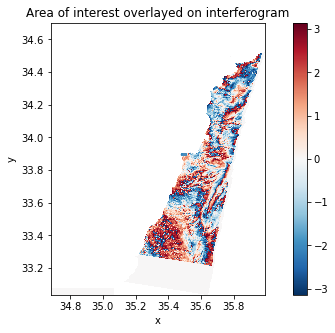

In [64]:
wholeIfg = rxr.open_rasterio(ifgPath, masked=True).squeeze()

poly = Polygon([[p['lng'], p['lat']] for p in testPoly.locations[0]])

f, ax = plt.subplots(figsize=(10, 5))
wholeIfg.plot.imshow(ax=ax)

extent = gpd.GeoSeries([poly])
extent.plot(ax=ax, alpha=.8)
ax.set(title="Area of interest overlayed on interferogram")
plt.show()

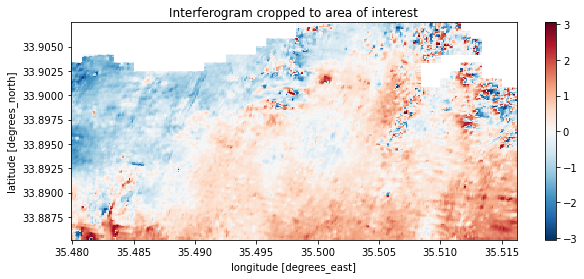

In [63]:
croppedIfg = wholeIfg.rio.clip(extent.geometry.apply(mapping), extent.crs)

f, ax = plt.subplots(figsize=(10, 4))
croppedIfg.plot(ax=ax)
ax.set(title="Interferogram cropped to area of interest")
plt.show()

In [103]:
croppedIfg.rio.to_raster(croppedPath)

In [6]:
named = croppedIfg.rename('ifg')
df = named.to_dataframe()

In [59]:
coords = np.concatenate(np.array(df.axes[0]))
initial = gpd.GeoDataFrame(pd.DataFrame(np.concatenate((np.ones([len(df),2])*0.5, np.array(df['ifg']).reshape(-1,1)), axis=1), columns = ['noDmg','dmg','ifg']), geometry=gpd.points_from_xy(coords[1::2], coords[0::2]),crs={'init': 'epsg:4326'})

In [235]:
# Plot interferogram on basemap
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom, scroll_wheel_zoom=True)
PIL.Image.fromarray((croppedIfg.data*255).astype('uint8')).convert('L').save('./data/cropped.png')
bounds = (min(np.array(croppedIfg.y)), min(np.array(croppedIfg.x))), (max(np.array(croppedIfg.y)), max(np.array(croppedIfg.x)))
image = image_overlay(url='./data/cropped.png', bounds=bounds, name = 'Interferogram')
ifl = m.add_layer(image)
m

Map(center=[33.8975, 35.5063], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [215]:
def image_overlay(url, bounds, name):
    """Overlays an image from the Internet or locally on the map.
    Args:
        url (str): http URL or local file path to the image.
        bounds (tuple): bounding box of the image in the format of (lower_left(lat, lon), upper_right(lat, lon)), such as ((13, -130), (32, -100)).
        name (str): name of the layer to show on the layer control.
    """
    if not url.startswith('http'):
        ext, image, f = os.path.splitext(url)[1][1:], PIL.Image.open(url), BytesIO()  # file extension
        image.save(f, ext)
        data = b64encode(f.getvalue()).decode('ascii')
        url = 'data:image/{};base64,'.format(ext) + data
        
    return ImageOverlay(url=url, bounds=bounds, name=name)